In [3]:
# %load_ext autoreload
# %autoreload 2

# import sys
# sys.path.append('..')

In [4]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from lib.obs import hourly_precip
from lib.enso import oni_trimonthly

## Load SFO rainfall

In [5]:
sfo_precip = hourly_precip('SFO', '1960-07-01', '2021-06-30', filter_measurable=False)

In [6]:
sfo_monthly = sfo_precip[['valid', 'precip_in']].resample('M', on='valid').sum().reset_index()
sfo_monthly['valid'] = sfo_monthly['valid'].to_numpy().astype('datetime64[M]')

In [7]:
sfo_monthly.head()

,valid,precip_in
0,1960-07-01,0.00
1,1960-08-01,0.00
2,1960-09-01,0.00
3,1960-10-01,0.28
4,1960-11-01,4.15


## Load ONI trimonthly

In [8]:
oni = oni_trimonthly()

In [9]:
oni['day'] = 1
oni['year'] = oni.YR
oni['date'] = pd.to_datetime(oni[['year', 'MONTH', 'day']])
oni = oni[['date', 'ANOM']]

oni.head()

,date,ANOM
0,1950-01-01,-1.53
1,1950-02-01,-1.34
2,1950-03-01,-1.16
3,1950-04-01,-1.18
4,1950-05-01,-1.07


## Load NCEP Reanalysis R1

In [10]:
ds_mon = xr.open_dataset('hgt.mon.mean.nc')
ds_mon_mean = xr.open_dataset('hgt.mon.ltm.nc')

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/core/indexing.py:568: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continu

In [13]:
def coerce_ltm_ds(ds, years):
    orig_times = ds.time.values
    concat_datasets = []
    for year in years:
        ds_for_year = ds.copy()
        newtimes = np.array([pd.Timestamp(year=year,
                                          month=t.month,
                                          day=t.day,
                                          hour=t.hour,
                                          minute=t.minute) for t in orig_times])
        ds_for_year['time'] = newtimes
        concat_datasets.append(ds_for_year)
        
    return xr.concat(concat_datasets, dim='time')

In [14]:
ds_mon_mean = coerce_ltm_ds(ds_mon_mean, range(1960, 2021))

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [15]:
def subset(p, years, months, bbox):
    def func(ds):
        kw = {}
        kw['level'] = p
        
        north, west, south, east = bbox
        kw['lon'] = slice(west, east)
        kw['lat'] = slice(north, south)
        
        time_query = np.in1d(ds['time.month'], months) & (np.in1d(ds['time.year'], years))
        kw['time'] = time_query
        
        return ds.sel(**kw)
    
    return func

In [16]:
# aleutians_bbox = (55, 170, 40, 200) # bad
aleutians_bbox = (65, 180, 45, 205)
hudson_bay_bbox = (65, 260, 50, 290)

years = range(1960, 2021)
djf = [12, 1, 2]
p = 500

In [17]:
aleutians = subset(p, years, djf, aleutians_bbox)
hudson_bay = subset(p, years, djf, hudson_bay_bbox)

h5_hgts_aleutians = aleutians(ds_mon)
h5_norms_aleutians = aleutians(ds_mon_mean)

h5_hgts_hudson = hudson_bay(ds_mon)
h5_norms_hudson = hudson_bay(ds_mon_mean)

In [18]:
h5_anoms_aleutians = h5_hgts_aleutians - h5_norms_aleutians
h5_anoms_hudson = h5_hgts_hudson - h5_norms_hudson

# h5_anoms_aleutians = h5_anoms_aleutians.sel(time=slice('1970-07-01', '2021-03-01'))
# h5_anoms_hudson = h5_anoms_hudson.sel(time=slice('1970-07-01', '2021-03-01'))

In [19]:
aleutians_anom_means = h5_anoms_aleutians.hgt.mean(['lat', 'lon'])
hudson_anom_means = h5_anoms_hudson.hgt.mean(['lat', 'lon'])

In [20]:
def correlation(x, y):
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy

In [21]:
correlation(aleutians_anom_means.values, hudson_anom_means.values)

-0.39670909049049224

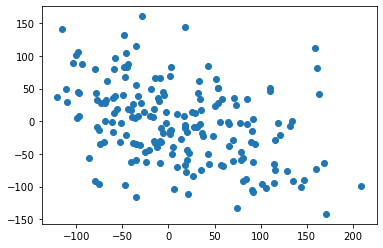

In [22]:
# plt.figure(figsize=(16, 16))

plt.scatter(aleutians_anom_means.values, hudson_anom_means.values)

In [23]:
aleutians_anom_df = aleutians_anom_means.to_dataframe().reset_index()[['time', 'hgt']]
hudson_anom_df = hudson_anom_means.to_dataframe().reset_index()[['time', 'hgt']]

## Merge together SFO rainfall, Aleutian heights, Hudson Bay heights, and ONI

In [24]:
full_df = sfo_monthly.merge(aleutians_anom_df, left_on='valid', right_on='time', how='right')
full_df = full_df.merge(hudson_anom_df, left_on='valid', right_on='time', 
                        how='inner', suffixes=['_al', '_hb'])
full_df = full_df[['valid','precip_in', 'hgt_al', 'hgt_hb']]
full_df = full_df.merge(oni, left_on='valid', right_on='date', how='left').rename(columns={'ANOM': 'oni'})

In [25]:
full_df.head()

,valid,precip_in,hgt_al,hgt_hb,date,oni
0,1960-12-01,1.16,-37.935349,-33.905144,1960-12-01,0.05
1,1961-01-01,2.63,-51.418720,-2.298860,1961-01-01,0.04
2,1961-02-01,1.18,-35.432648,55.791924,1961-02-01,0.03
3,1961-12-01,1.88,51.670059,64.212524,1961-12-01,-0.16
4,1962-01-01,1.70,114.406311,-93.969200,1962-01-01,-0.24


In [26]:
full_df_nonino = full_df[full_df.oni < 1.5]

In [27]:
mean = full_df.precip_in.mean()
median = full_df.precip_in.median()
sd = full_df.precip_in.std()

median, sd, mean

(2.9448, 2.8175236674833326, 3.54230773480663)

In [43]:
low_bucket = full_df[full_df.precip_in <= mean - 0.67*sd]
high_bucket = full_df[full_df.precip_in >= mean + 0.5*sd]
mean_bucket = full_df[(full_df.precip_in > mean - 0.67*sd) & (full_df.precip_in < mean + 0.5*sd)]
# median_bucket = full_df[(full_df.precip_in >= median - sd) & (full_df.precip_in <= median + sd)]

len(low_bucket), len(high_bucket), len(mean_bucket)

(56, 50, 75)

In [44]:
full_df.hgt_al.std(), full_df.hgt_hb.std()

(71.561325, 59.561466)

(-180.0, 180.0)

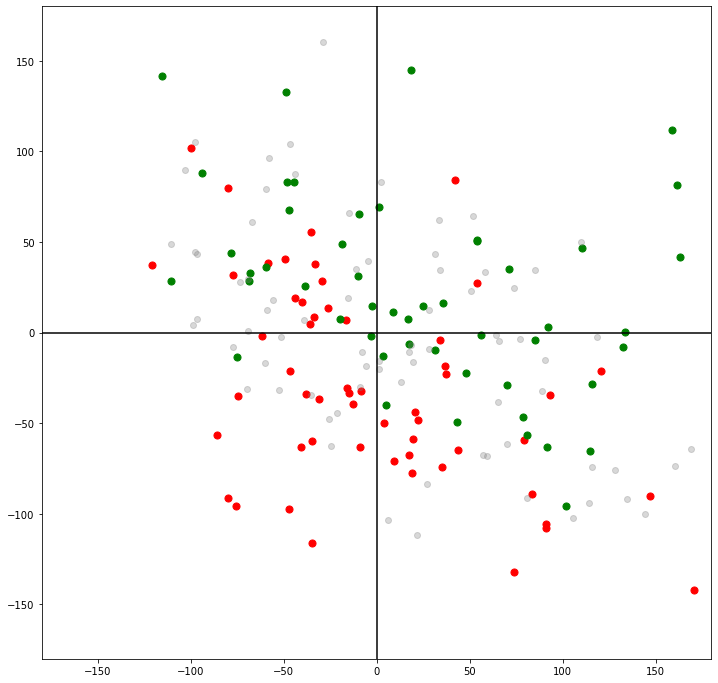

In [45]:
plt.figure(figsize=(12, 12))
plt.scatter(low_bucket.hgt_al, low_bucket.hgt_hb, color='red', s=50)
plt.scatter(high_bucket.hgt_al, high_bucket.hgt_hb, color='green', s=50)
plt.scatter(mean_bucket.hgt_al, mean_bucket.hgt_hb, color='gray', alpha=0.3)
# plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlim([-180, 180])
plt.ylim([-180, 180])

# circ = plt.Circle((0, 0), 20, color='k', fill=False, ls='--')
# circ2 = plt.Circle((0, 0), 50, color='k', fill=False, ls='--')
# plt.gca().add_patch(circ)
# plt.gca().add_patch(circ2)

In [46]:
threshold = 30
df_to_use = full_df

circle_of_death = (df_to_use.hgt_al ** 2 + df_to_use.hgt_hb ** 2) < threshold ** 2

q1 = df_to_use[(df_to_use.hgt_al < 0) & (df_to_use.hgt_hb < 0) & ~circle_of_death]
q2 = df_to_use[(df_to_use.hgt_al < 0) & (df_to_use.hgt_hb > 0) & ~circle_of_death]
q3 = df_to_use[(df_to_use.hgt_al > 0) & (df_to_use.hgt_hb > 0) & ~circle_of_death]
q4 = df_to_use[(df_to_use.hgt_al > 0) & (df_to_use.hgt_hb < 0) & ~circle_of_death]

len(q1), len(q2), len(q3), len(q4)

(28, 50, 25, 59)

{'whiskers': [<matplotlib.lines.Line2D at 0x11dcfef40>,
 'caps': [<matplotlib.lines.Line2D at 0x11dd0b640>,
 'boxes': [<matplotlib.lines.Line2D at 0x11dcfebe0>,
 'medians': [<matplotlib.lines.Line2D at 0x11dd0bd00>,
 'fliers': [<matplotlib.lines.Line2D at 0x11dd160a0>,
 'means': []}

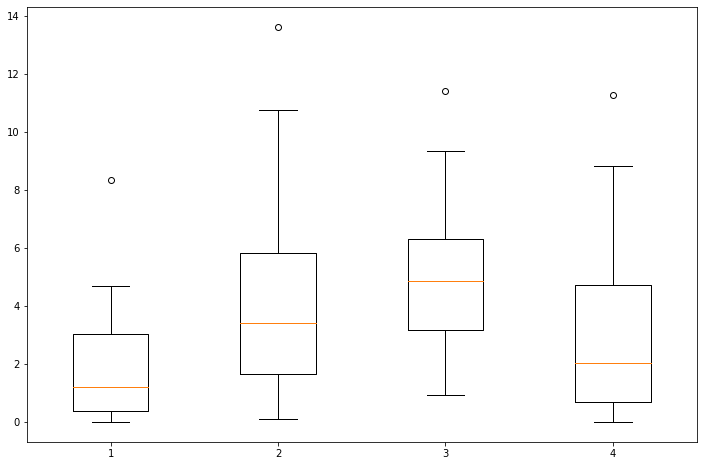

In [47]:
plt.figure(figsize=(12, 8))
plt.boxplot([q1.precip_in, q2.precip_in, q3.precip_in, q4.precip_in])
# plt.ylim([-0.5, 10])

{'bodies': [<matplotlib.collections.PolyCollection at 0x11dda5400>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11dda5220>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e1d6280>,
 'cbars': <matplotlib.collections.LineCollection at 0x11e1d6610>}

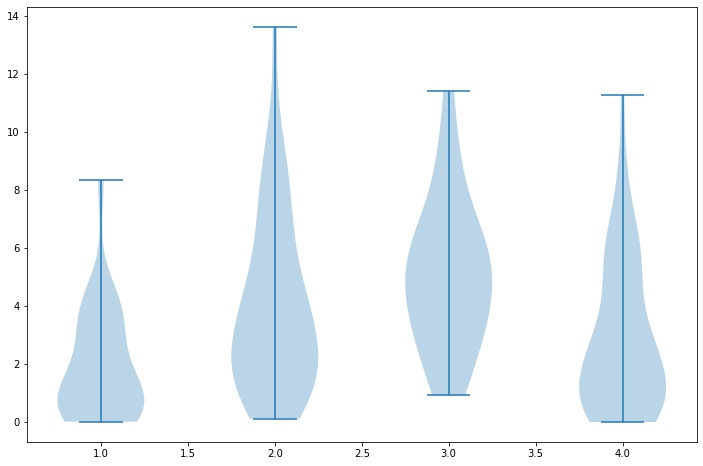

In [48]:
plt.figure(figsize=(12, 8))
plt.violinplot([q1.precip_in, q2.precip_in, q3.precip_in, q4.precip_in])

## Find correlations between ONI and Hudson Bay/Aleutian heights

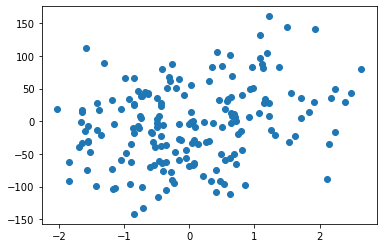

In [34]:
plt.scatter(full_df.oni, full_df.hgt_hb)

In [39]:
full_df[(full_df.hgt_hb < -30) & (full_df.oni > 1)]

,valid,precip_in,hgt_al,hgt_hb,date,oni
36,1972-12-01,0.72,83.777237,-88.918648,1972-12-01,2.12
93,1991-12-01,2.70,-69.881912,-31.133457,1991-12-01,1.53
167,2016-02-01,0.88,-74.276833,-35.240620,2016-02-01,2.14


In [36]:
correlation(full_df.oni, full_df.hgt_hb)

0.27917407534584693

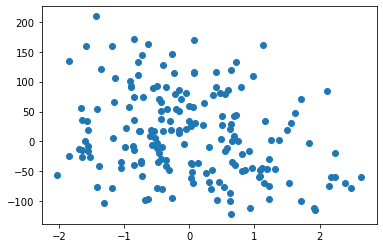

In [37]:
plt.scatter(full_df.oni, full_df.hgt_al)

In [38]:
correlation(full_df.oni, full_df.hgt_al)

-0.2698784052388924